18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Performance for Next 144 Blocks:
Mean Absolute Error: 3.2496
Mean Squared Error: 14.7445
Root Mean Squared Error: 3.8399
R-squared Score: -0.19703284991983705
MAPE: 88.7170%
Directional Accuracy: 41.9580%
Theil's U Statistic: 0.6532
Training time: 8.291117191314697s


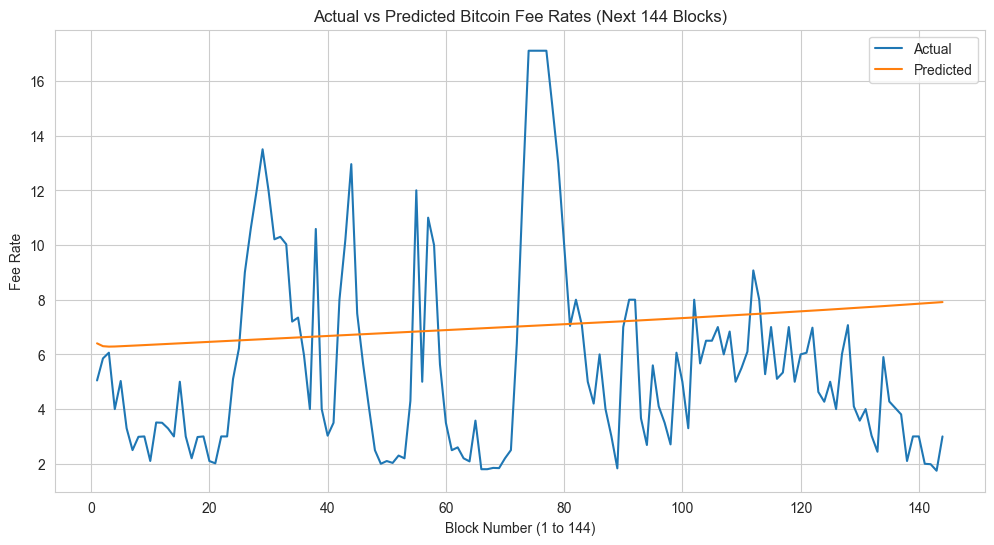

In [8]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random
# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)


# Call the function to set the seed
set_seed(42)
start=time.time()

df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Prepare data_history for Prophet
prophet_df = df[['block_time', 'block_median_fee_rate']].rename(columns={'block_time': 'ds', 'block_median_fee_rate': 'y'})

# Add essential features
prophet_df['hour'] = prophet_df['ds'].dt.hour
prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
prophet_df['is_weekend'] = prophet_df['day_of_week'].isin([5, 6]).astype(int)
prophet_df['fee_lag_1'] = prophet_df['y'].shift(1)
prophet_df['tx_count'] = df['tx_count']
prophet_df['mempool_size_mb'] = df['mempool_size_mb']
prophet_df['hash_rate'] = df['hash_rate']
prophet_df['avg_fee_rate'] = df['avg_fee_rate']
prophet_df['bitcoin_price_usd'] = df['bitcoin_price_usd']
prophet_df['block_height'] = df['block_height']
prophet_df['max_fee_rate'] = df['max_fee_rate']
prophet_df['difficulty'] = df['difficulty']
prophet_df['block_weight'] = df['block_weight']
prophet_df['block_version'] = df['block_version']
prophet_df['mempool_usage'] = df['mempool_usage']

# Remove rows with NaN values (since lagged features are introduced)
prophet_df = prophet_df.dropna()

# Split data_history for training
train_size = len(prophet_df) - 144 # Change here to 10 if want to predict next 10 blocks
train_df = prophet_df[:train_size]

# Create and fit Prophet model
model = Prophet(
    changepoint_prior_scale=2.0,  # Increased to better capture abrupt changes
    seasonality_prior_scale=10,   # Adjusted for better seasonality flexibility
    holidays_prior_scale=5,
    daily_seasonality=False,      # Removed daily seasonality
    weekly_seasonality=False,     # Custom weekly seasonality will be added
    yearly_seasonality=False,
    seasonality_mode='additive'
)

# Add custom seasonalities
model.add_seasonality(name='weekly', period=7, fourier_order=3)  # Reduced fourier order to avoid overfitting

# Add regressors
regressors = ['hour', 'day_of_week', 'is_weekend', 'fee_lag_1', 'tx_count', 'mempool_size_mb', 'hash_rate', 'avg_fee_rate', 'bitcoin_price_usd', 'block_height', 'max_fee_rate', 'difficulty', 'block_weight', 'block_version', 'mempool_usage']


for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model on the training data_history
model.fit(train_df)

# Start recursive prediction for the next 144 blocks
last_known_data = train_df.copy().iloc[-1]
future_predictions = []

for i in range(144):# Change here to 10 if want to predict next 10 blocks
    # Prepare the data_history for the next prediction
    next_input = pd.DataFrame([last_known_data[['ds'] + regressors].fillna(0)])
    future = model.predict(next_input)
    yhat = future['yhat'].values[0]
    
    # Append the prediction to the list of predictions
    future_predictions.append({'ds': last_known_data['ds'] + pd.Timedelta(minutes=10), 'y': yhat})  # Assuming 10-minute intervals

    # Update the features using the predicted value
    new_data = last_known_data.copy()
    new_data['ds'] = new_data['ds'] + pd.Timedelta(minutes=10)
    new_data['y'] = yhat
    new_data['fee_lag_1'] = yhat
    new_data['tx_count'] = last_known_data['tx_count']  # Replace with predicted or estimated value if available
    new_data['mempool_size_mb'] = last_known_data['mempool_size_mb']
    new_data['hash_rate'] = last_known_data['hash_rate']
    new_data['avg_fee_rate'] = last_known_data['avg_fee_rate']
    new_data['bitcoin_price_usd'] = last_known_data['bitcoin_price_usd']
    new_data['block_height'] = last_known_data['block_height']
    new_data['max_fee_rate'] = last_known_data['max_fee_rate']
    new_data['difficulty'] = last_known_data['difficulty']
    new_data['block_weight'] = last_known_data['block_weight']
    new_data['block_version'] = last_known_data['block_version']
    new_data['mempool_usage'] = last_known_data['mempool_usage']

    # Update the last known data_history for the next iteration
    last_known_data = new_data

# Convert future predictions to a DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Ensure y_true and y_pred have the same length
y_pred = future_predictions_df['y'].values
y_true = prophet_df['y'][-len(y_pred):].values

# Remove any NaNs from the evaluation data_history
y_true = y_true[~np.isnan(y_true)]
y_pred = y_pred[~np.isnan(y_pred)]

# Ensure y_true and y_pred are still consistent in length
y_true = y_true[:len(y_pred)]
y_pred = y_pred[:len(y_true)]

# Evaluate the model
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator

end=time.time()
mape = mean_absolute_percentage_error(y_true, y_pred)
da = directional_accuracy(y_true, y_pred)
theils_u = theil_u(y_true, y_pred)
print("\nProphet Model Performance for Next 144 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start}s")

# Plot actual vs. predicted
# plt.figure(figsize=(12, 6))
# plt.plot(prophet_df['ds'][-len(y_true):], y_true, label='Actual')
# plt.plot(future_predictions_df['ds'][:len(y_pred)], y_pred, label='Predicted')
# plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
# plt.xlabel('Time')
# plt.ylabel('Fee Rate')
# plt.legend()
# plt.show()


# Plot actual vs. predicted for the last 10 blocks
plt.figure(figsize=(12, 6))


plt.plot(range(1, len(y_true) + 1), y_true, label='Actual')
plt.plot(range(1, len(y_pred) + 1), y_pred, label='Predicted')

plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Block Number (1 to 144)')
plt.ylabel('Fee Rate')

plt.legend()
plt.show()

In [3]:
df.shape

(2632, 26)

In [4]:
y_pred

array([2.4173197 , 2.46670604, 2.47834193, 2.48605986, 2.49332663,
       2.50049762, 2.50760941, 2.51466589, 2.52166765, 2.52861492])

## Backtesting, which takes a long time. So I use cross validation as following.



20:12:04 - cmdstanpy - INFO - Chain [1] start processing
20:12:07 - cmdstanpy - INFO - Chain [1] done processing


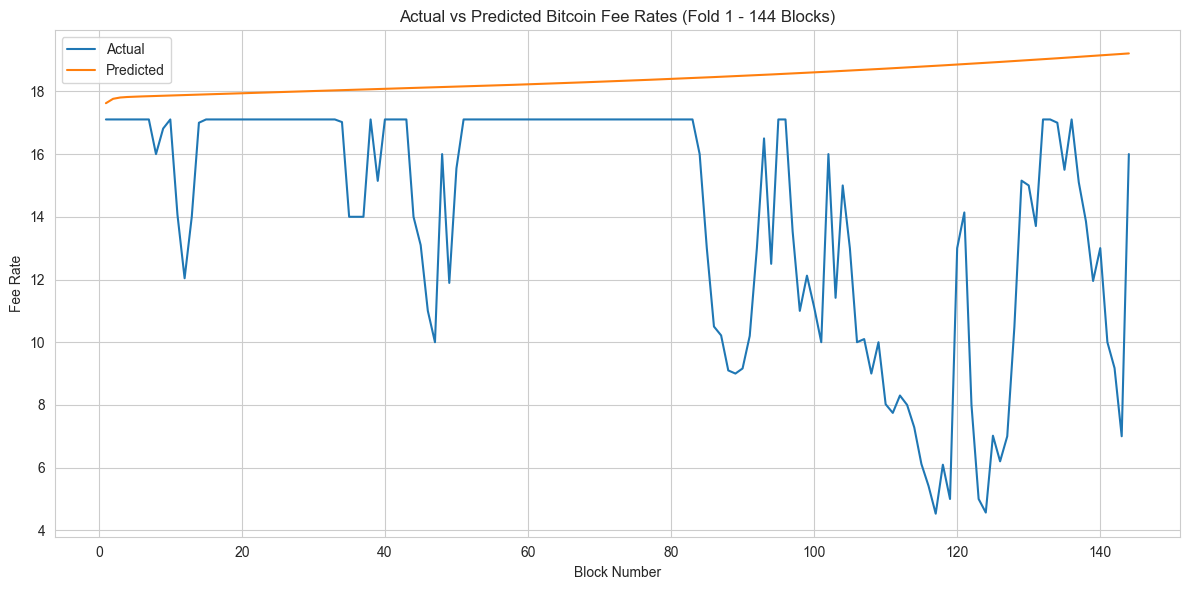

20:12:09 - cmdstanpy - INFO - Chain [1] start processing
20:12:11 - cmdstanpy - INFO - Chain [1] done processing


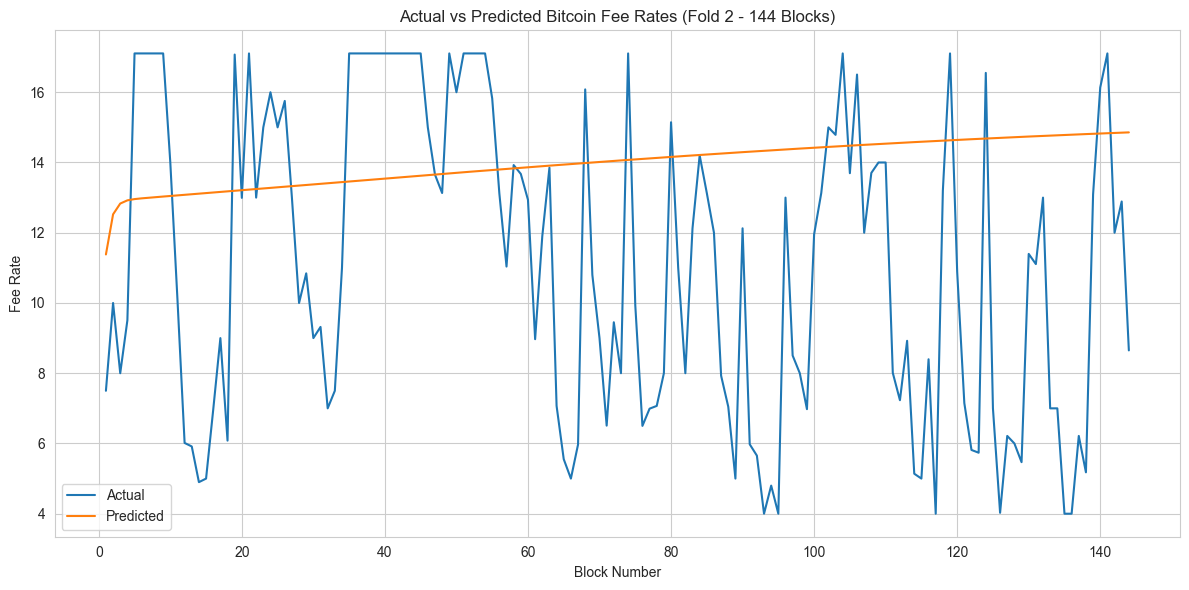

20:12:13 - cmdstanpy - INFO - Chain [1] start processing
20:12:15 - cmdstanpy - INFO - Chain [1] done processing


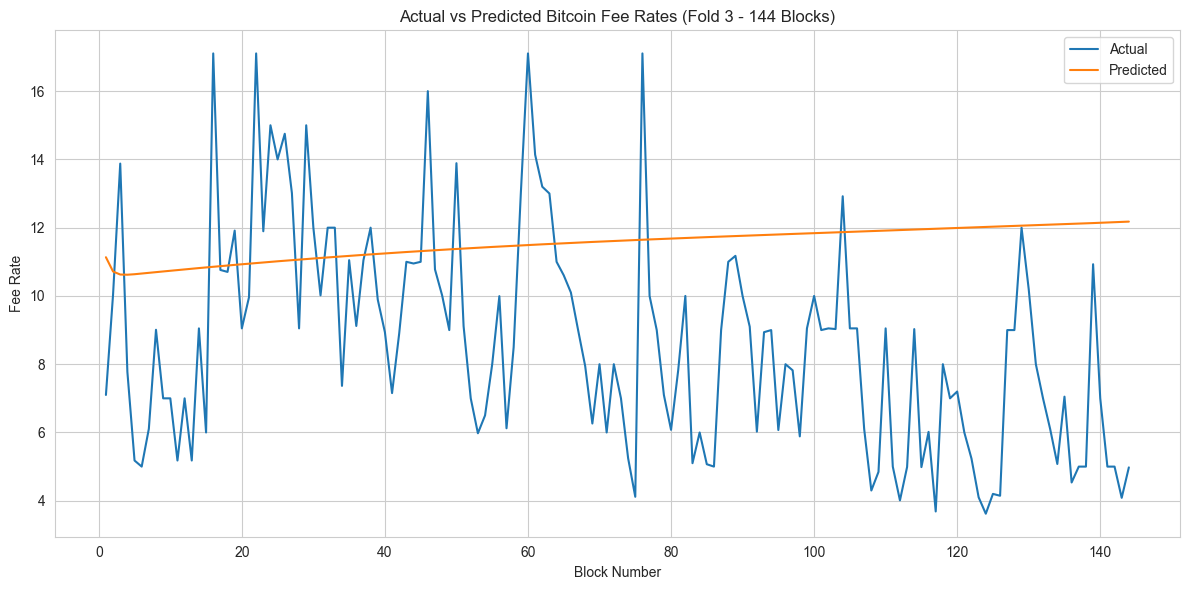

20:12:18 - cmdstanpy - INFO - Chain [1] start processing
20:12:20 - cmdstanpy - INFO - Chain [1] done processing


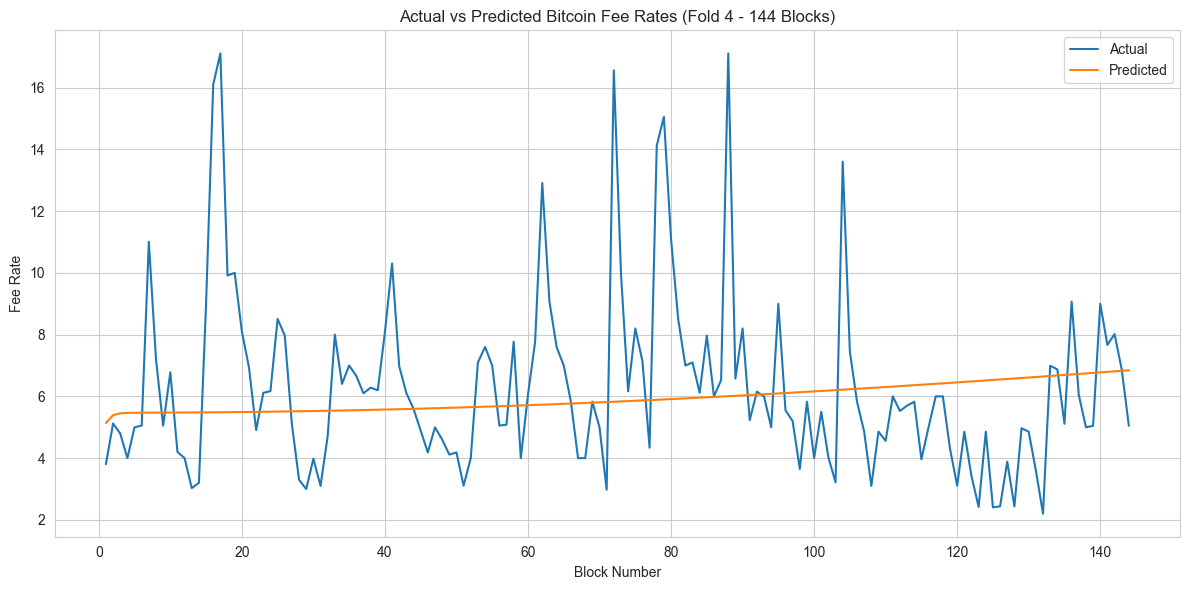

20:12:23 - cmdstanpy - INFO - Chain [1] start processing
20:12:25 - cmdstanpy - INFO - Chain [1] done processing


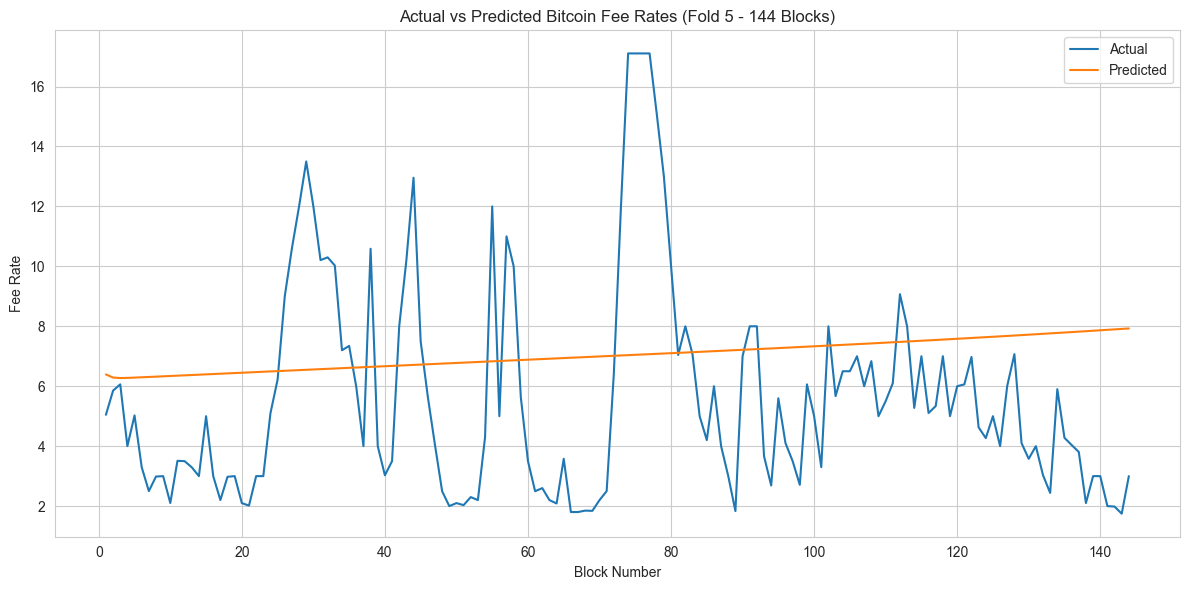


Cross-Validation Performance (Using Predicted Features):
Mean Absolute Error (CV): 3.5499
Root Mean Squared Error (CV): 4.4851
R-squared Score (CV): -0.6231
MAPE (CV): 58.4797%
Theil's U Statistic (CV): 0.6106
Directional Accuracy (CV): 36.9231%
Training and Prediction time: 23.02s


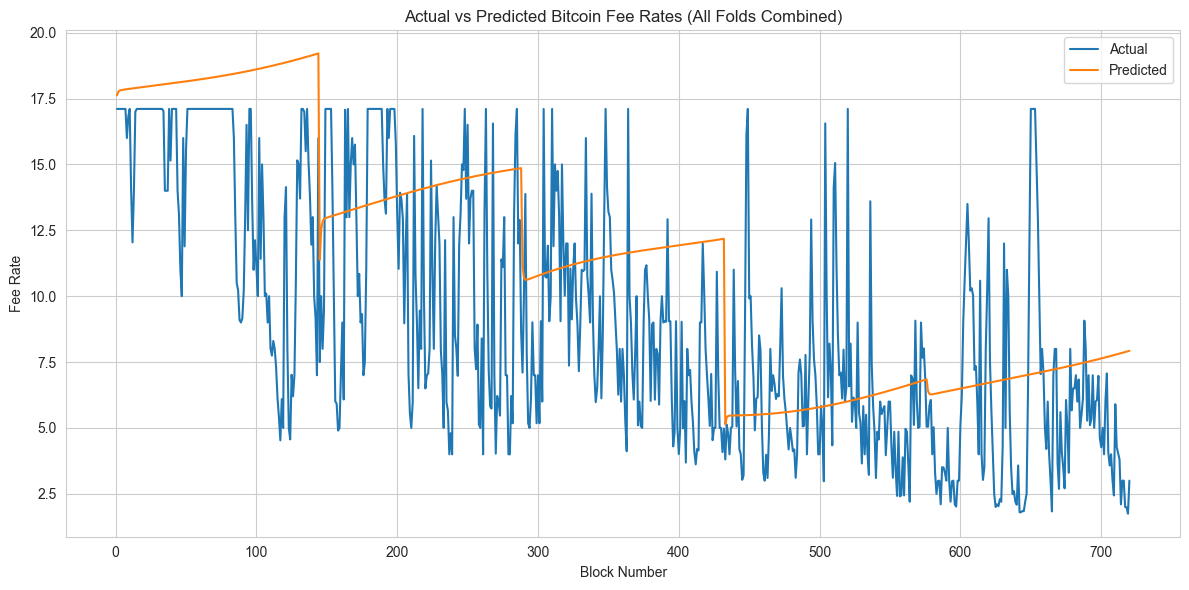

In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# Call the function to set the seed
set_seed(42)
start = time.time()

# Load and preprocess data_history
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

# Prepare data_history for Prophet
prophet_df = df[['block_time', 'block_median_fee_rate']].rename(columns={'block_time': 'ds', 'block_median_fee_rate': 'y'})

# Add essential features
prophet_df['hour'] = prophet_df['ds'].dt.hour
prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
prophet_df['is_weekend'] = prophet_df['day_of_week'].isin([5, 6]).astype(int)
prophet_df['fee_lag_1'] = prophet_df['y'].shift(1)
prophet_df['tx_count'] = df['tx_count']
prophet_df['mempool_size_mb'] = df['mempool_size_mb']
prophet_df['hash_rate'] = df['hash_rate']
prophet_df['avg_fee_rate'] = df['avg_fee_rate']
prophet_df['bitcoin_price_usd'] = df['bitcoin_price_usd']
prophet_df['block_height'] = df['block_height']
prophet_df['max_fee_rate'] = df['max_fee_rate']
prophet_df['difficulty'] = df['difficulty']
prophet_df['block_weight'] = df['block_weight']
prophet_df['block_version'] = df['block_version']
prophet_df['mempool_usage'] = df['mempool_usage']

# Remove rows with NaN values (since lagged features are introduced)
prophet_df = prophet_df.dropna()

# Custom TimeSeriesSplit with 144 blocks as test set
test_size = 144
n_splits = 5  # can change the number of splits based on the data

# Initialize lists to store cross-validation results
cv_predictions = []
cv_actuals = []
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []
theil_u_scores = []
da_scores = []

# To store cumulative predictions and actuals for the whole test dataset across all folds
all_y_true = []
all_y_pred = []

# Regressors to add to the model
regressors = ['hour', 'day_of_week', 'is_weekend', 'fee_lag_1', 'tx_count', 'mempool_size_mb', 
              'hash_rate', 'avg_fee_rate', 'bitcoin_price_usd', 'block_height', 'max_fee_rate', 
               'difficulty','block_weight', 'block_version', 'mempool_usage']  #

# Custom TimeSeriesSplit loop
n_total = len(prophet_df)
for fold_idx in range(n_splits):
    train_end = n_total - (n_splits - fold_idx) * test_size
    test_start = train_end
    test_end = test_start + test_size

    # Train and test sets
    train_window = prophet_df.iloc[:train_end]
    test_window = prophet_df.iloc[test_start:test_end]

    # Create and fit Prophet model
    model = Prophet(
        changepoint_prior_scale=4.0,  # Increased to better capture abrupt changes
        seasonality_prior_scale=8,   # Regularization for seasonality
        holidays_prior_scale=6,
        daily_seasonality=False,      # Removed daily seasonality
        yearly_seasonality=False,
        seasonality_mode='additive'
    )

    # Add regressors to the model
    for regressor in regressors:
        model.add_regressor(regressor)

    # Fit the model on the training data_history
    model.fit(train_window)

    # Prepare for recursive prediction over the test set
    last_known_data = train_window.copy().iloc[-1]
    future_predictions = []

    # Predict for the next 144 blocks (test set)
    for i in range(test_size):  # Predict for 144 blocks only
        next_input = pd.DataFrame([last_known_data[['ds'] + regressors].fillna(0)])
        future = model.predict(next_input)
        yhat = future['yhat'].values[0]

        # Append the prediction
        future_predictions.append({'ds': last_known_data['ds'] + pd.Timedelta(minutes=10), 'y': yhat})

        # Update the features using the predicted value
        new_data = last_known_data.copy()
        new_data['ds'] = new_data['ds'] + pd.Timedelta(minutes=10)
        new_data['y'] = yhat
        new_data['fee_lag_1'] = yhat
        new_data['tx_count'] = last_known_data['tx_count']
        new_data['mempool_size_mb'] = last_known_data['mempool_size_mb']
        new_data['hash_rate'] = last_known_data['hash_rate']
        new_data['avg_fee_rate'] = last_known_data['avg_fee_rate']
        new_data['bitcoin_price_usd'] = last_known_data['bitcoin_price_usd']
        new_data['block_height'] = last_known_data['block_height']
        new_data['max_fee_rate'] = last_known_data['max_fee_rate']
        new_data['difficulty'] = last_known_data['difficulty']
        new_data['block_weight'] = last_known_data['block_weight']
        new_data['block_version'] = last_known_data['block_version']
        new_data['mempool_usage'] = last_known_data['mempool_usage']

        # Update last_known_data for next iteration
        last_known_data = new_data

    # Convert predictions to DataFrame
    future_predictions_df = pd.DataFrame(future_predictions)

    # Get actual values from the test window, limit to 144 blocks
    y_true = test_window['y'].values[:test_size]  # Only take the first 144 actual values
    y_pred = future_predictions_df['y'].values[:test_size]  # Only the first 144 predicted values

    # Append predictions and actuals to cumulative lists
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    # Plot actual vs predicted for the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true) + 1), y_true, label='Actual')
    plt.plot(range(1, len(y_pred) + 1), y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1} - 144 Blocks)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate performance for this fold
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Additional performance metrics
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def directional_accuracy(y_true, y_pred):
        return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

    def theil_u(y_true, y_pred):
        y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
        y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
        numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
        denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
        return numerator / denominator

    mape = mean_absolute_percentage_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)
    theil_u_stat = theil_u(y_true, y_pred)

    # Append metrics to lists
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)
    theil_u_scores.append(theil_u_stat)
    da_scores.append(da)

# Compute the mean of all metrics
mae_cv = np.mean(mae_scores)
rmse_cv = np.mean(rmse_scores)
r2_cv = np.mean(r2_scores)
mape_cv = np.mean(mape_scores)
theil_u_cv = np.mean(theil_u_scores)
da_cv = np.mean(da_scores)

end = time.time()

# Print cross-validation results
print("\nCross-Validation Performance (Using Predicted Features):")
print(f"Mean Absolute Error (CV): {mae_cv:.4f}")
print(f"Root Mean Squared Error (CV): {rmse_cv:.4f}")
print(f"R-squared Score (CV): {r2_cv:.4f}")
print(f"MAPE (CV): {mape_cv:.4f}%")
print(f"Theil's U Statistic (CV): {theil_u_cv:.4f}")
print(f"Directional Accuracy (CV): {da_cv:.4f}%")
print(f"Training and Prediction time: {end-start:.2f}s")

# Plot the cumulative results for all folds
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(all_y_true) + 1), all_y_true, label='Actual')
plt.plot(range(1, len(all_y_pred) + 1), all_y_pred, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (All Folds Combined)')
plt.xlabel('Block Number')
plt.ylabel('Fee Rate')
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define your features (regressors) and target
X = prophet_df[regressors]
y = prophet_df['y']

# Train a Random Forest Regressor to assess feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                   importance
avg_fee_rate         0.759944
fee_lag_1            0.136004
tx_count             0.026312
block_height         0.012382
bitcoin_price_usd    0.010843
mempool_usage        0.008766
hash_rate            0.007850
max_fee_rate         0.007632
mempool_size_mb      0.007373
block_version        0.006254
hour                 0.005754
block_weight         0.005401
day_of_week          0.004184
difficulty           0.000779
is_weekend           0.000522


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the data_history for VIF calculation
X = prophet_df[regressors]  # Select the features for VIF analysis
X = X.dropna()  # Drop missing values

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


              Feature        VIF
0                hour   1.008679
1         day_of_week   1.015365
2          is_weekend   1.049978
3           fee_lag_1   1.138601
4            tx_count   1.166688
5     mempool_size_mb  30.771315
6           hash_rate   1.522484
7        avg_fee_rate   1.253205
8   bitcoin_price_usd   1.038491
9        block_height   0.008616
10       max_fee_rate   1.067754
11         difficulty   0.081865
12       block_weight   0.000016
13      block_version   0.988025
14      mempool_usage   1.007857
